# Introduction

The project deals with a regression task to predict the revenue of restaurant. We are given with a small dataset with 100 entries. 

# Exploratory data analysis

## Data info

In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.api import OLS, add_constant
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f'%x)

In [204]:
df = pd.read_csv('data/revenue_prediction.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
df.head()

,name,franchise,category,city,no_of_item,order_placed,revenue
Id,,,,,,,
101,HungryHowie'sPizza,Yes,Mexican,Bengaluru,55,5.50000,5953753
102,CharleysPhillySteaks,No,Varied Menu,Gurugram,72,6.80000,7223131
103,Chuy's,Yes,Chicken,Pune,25,1.90000,2555379
104,O'Charley's,Yes,Italian/Pizza,Mumbai,18,2.50000,2175511
105,PolloTropical,Yes,Pizza,Noida,48,4.20000,4816715


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 101 to 200
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          100 non-null    object 
 1   franchise     100 non-null    object 
 2   category      100 non-null    object 
 3   city          100 non-null    object 
 4   no_of_item    100 non-null    int64  
 5   order_placed  100 non-null    float64
 6   revenue       100 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.2+ KB


The info shows there are no non-null values. There are 4 features with object datatypes.

## Object data description

In [206]:
df.describe(include='object').T

,count,unique,top,freq
name,100,100,HungryHowie'sPizza,1
franchise,100,2,Yes,55
category,100,20,Varied Menu,16
city,100,5,Bengaluru,43


From the above table, we see name has 100 unique values and will not help in model training. We will remove the name column.

In [207]:
df.drop(columns='name', inplace=True)

In [208]:
df.select_dtypes('object').apply(lambda x: x.unique())

franchise                                            [Yes, No]
category     [Mexican, Varied Menu, Chicken, Italian/Pizza,...
city                [Bengaluru, Gurugram, Pune, Mumbai, Noida]
dtype: object

Based on the unique values, we can see that the features `category` and `city` are nominal, where we use one-hot encoding. The feature `franchise` is ordinal binary variable. Using one-hot encoder with dropping one column works exactly as label encoder. So, to make the pipeline simple, we will use one-hot encoder for all three categorical features.

## Numerical data description

In [209]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
no_of_item,100.00000,49.08000,22.37092,18.00000,34.75000,45.00000,57.25000,126.00000
order_placed,100.00000,4.08600,2.05510,1.00000,2.75000,3.65000,5.10000,13.00000
revenue,100.00000,4395160.90000,2659932.18829,849870.00000,2688328.50000,3911401.00000,5330084.00000,19696939.00000


From the description, we can see a moderate positive skewness on all three variables, as the mean is greater than the median. Also, the target `revenue` may have outliers which should be processed.

We will create three variables, categorical, numerical and target for easier access.

In [210]:
categorical = df.select_dtypes('object').columns
numerical = df.select_dtypes(np.number).columns[:-1]
target = 'revenue'

# Visualization

## Univariate analysis

### Histogram: Numerical features

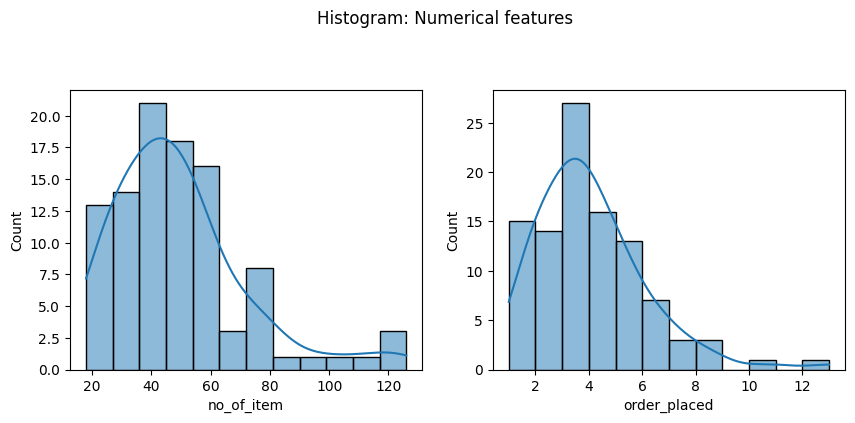

In [211]:
fig, ax = plt.subplots(nrows=len(numerical) // 2 + 1, ncols=2, figsize=(10, len(numerical)*4))

for i, col in enumerate(numerical):
    ind = divmod(i, 2)
    sns.histplot(df, x=col, ax=ax[ind], kde=True)

fig.delaxes(ax[len(numerical)//2, 1])
if len(numerical)%2 == 0:
    fig.delaxes(ax[len(numerical)//2, 0])

fig.suptitle('Histogram: Numerical features');

The distribution is skewed to the right (positive skew). Let us visualize how the log of features are distributed.

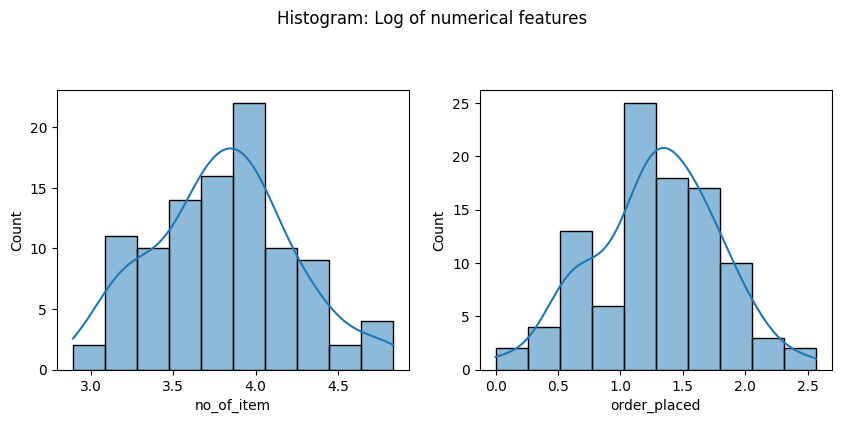

In [212]:
fig, ax = plt.subplots(nrows=len(numerical) // 2 + 1, ncols=2, figsize=(10, len(numerical)*4))

for i, col in enumerate(numerical):
    ind = divmod(i, 2)
    sns.histplot(np.log(df[col]), ax=ax[ind], kde=True)

fig.delaxes(ax[len(numerical)//2, 1])
if len(numerical)%2 == 0:
    fig.delaxes(ax[len(numerical)//2, 0])

fig.suptitle('Histogram: Log of numerical features');

The log of numerical features is closely a bell-curve. We will use the log of numerical features as the input to the model.

### Box-plot: Log of numerical features

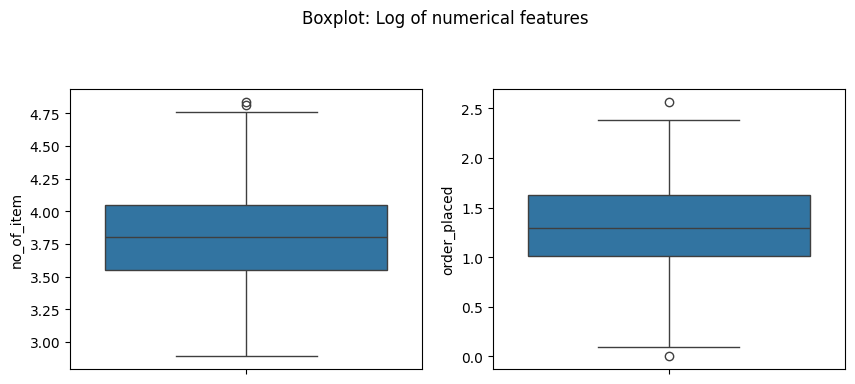

In [213]:
fig, ax = plt.subplots(nrows=len(numerical) // 2 + 1, ncols=2, figsize=(10, len(numerical)*4))

for i, col in enumerate(numerical):
    ind = divmod(i, 2)
    sns.boxplot(np.log(df[col]), ax=ax[ind])

fig.delaxes(ax[len(numerical)//2, 1])
if len(numerical)%2 == 0:
    fig.delaxes(ax[len(numerical)//2, 0])

fig.suptitle('Boxplot: Log of numerical features');

The boxplot shows only very few outliers. We will process them after further analysis.

### Countplot: categorical features

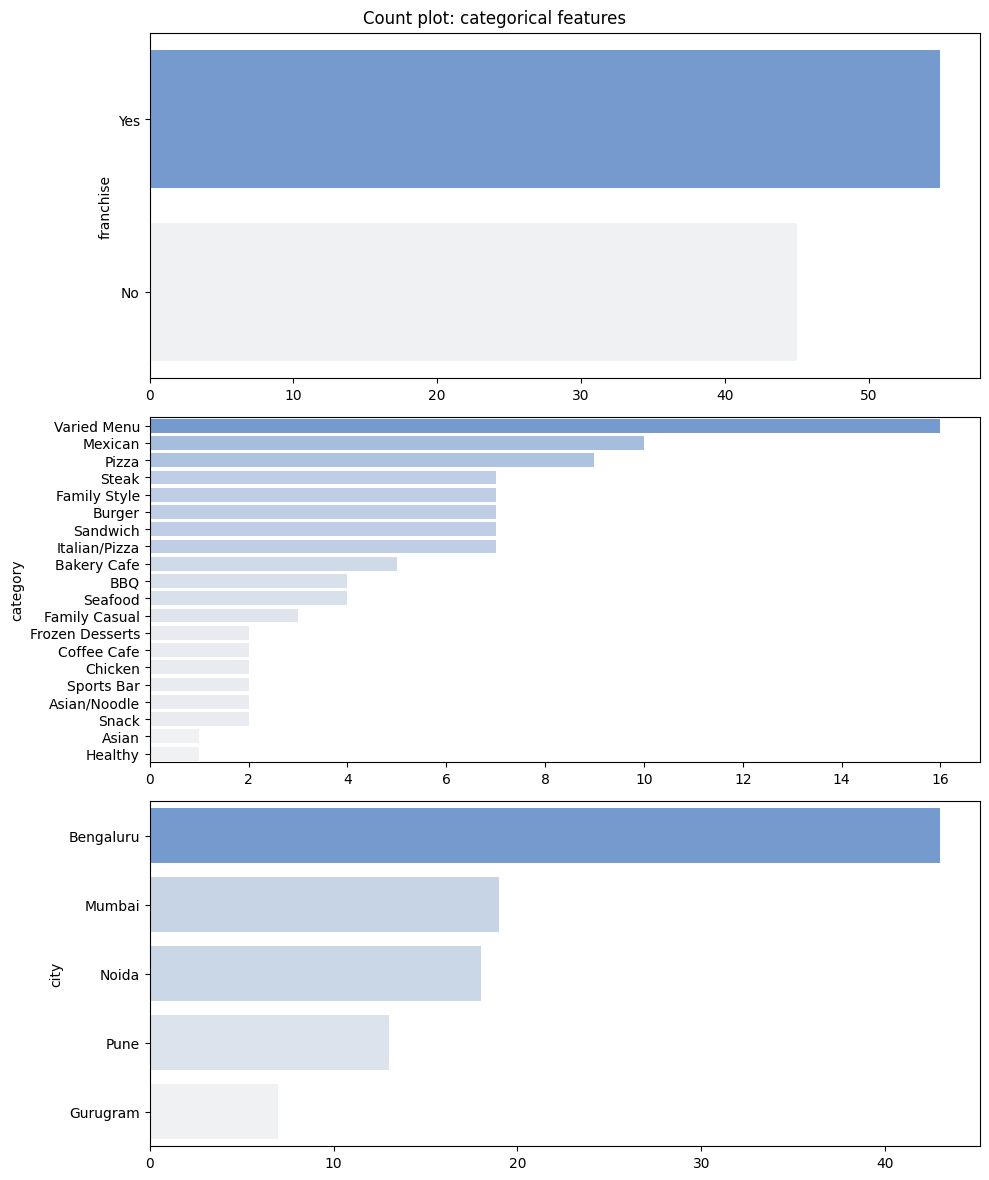

In [214]:
fig, ax = plt.subplots(nrows=len(categorical), ncols=1, figsize=(10, len(categorical)*4))

for i, col in enumerate(categorical):
    counts = df[col].value_counts()
    counts = (counts - counts.min()) / (counts.max() - counts.min())
    order = counts.index
    palette = sns.light_palette('#69d', as_cmap=True)
    mapping = {value: palette(norm_count) for value, norm_count in zip(order, counts)}
    sns.countplot(df, y=col, ax=ax[i], order=order, palette=mapping)
    ax[i].set_xlabel('')

fig.suptitle('Count plot: categorical features')
plt.tight_layout()

We can see from the countplot that restaurant with franchise are more common than the one without franchise. The restaurants with varied menu are the most common. The sample has most of the restaurants from Bengaluru.

### Histogram: target

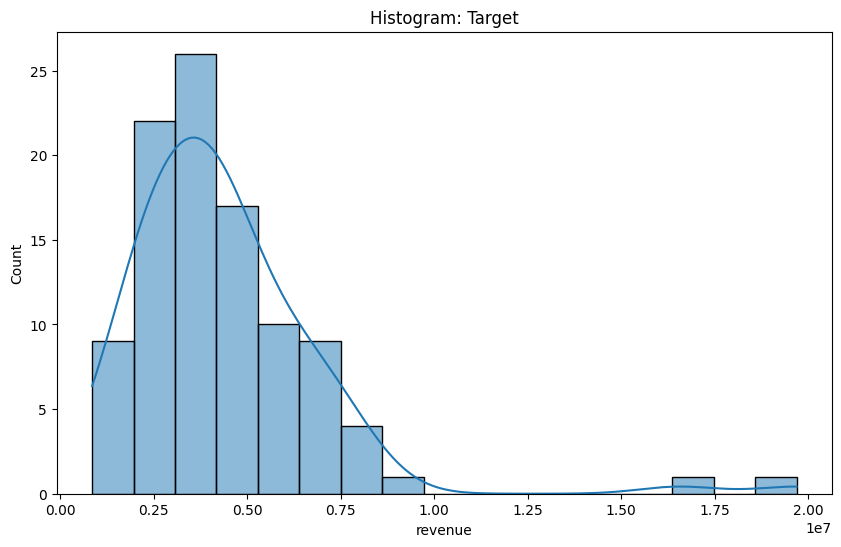

In [215]:
plt.subplots(figsize=(10, 6))

sns.histplot(df, x=target, kde=True)
plt.title('Histogram: Target');

The histogram shows the target is skewed to the right. There are two outliers in the data, which we will process in later stage. Let's visualize how the distribution of the log of targets look.

### Histogram: Log of target

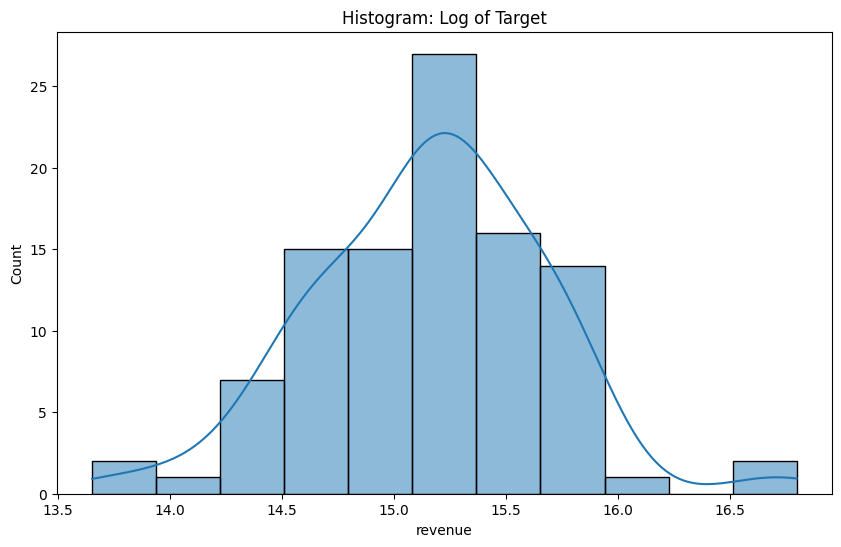

In [216]:
plt.subplots(figsize=(10, 6))

sns.histplot(np.log(df[target]), kde=True)
plt.title('Histogram: Log of Target');

The log of targets resemble normal distribution. We will use the log of targets as the target vector.

## Bivariate analysis

### Scatter plot: Numerical features vs target

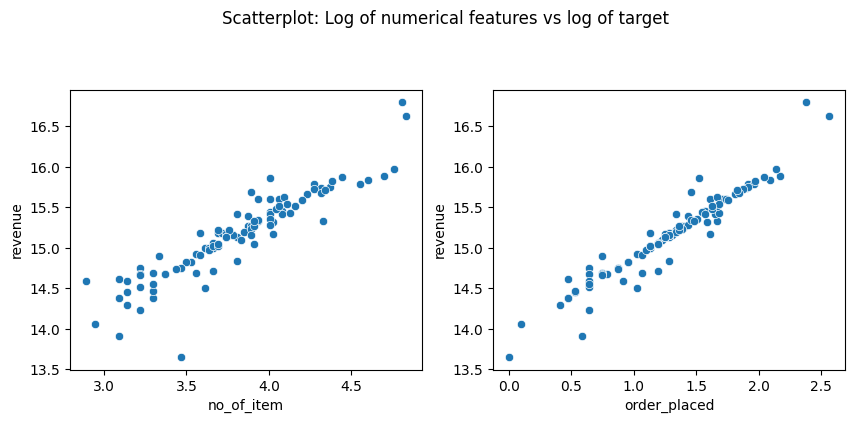

In [217]:
fig, ax = plt.subplots(nrows=len(numerical) // 2 + 1, ncols=2, figsize=(10, len(numerical)*4))

for i, col in enumerate(numerical):
    ind = divmod(i, 2)
    sns.scatterplot(x=np.log(df[col]), y=np.log(df[target]), ax=ax[ind])

fig.delaxes(ax[len(numerical)//2, 1])
if len(numerical)%2 == 0:
    fig.delaxes(ax[len(numerical)//2, 0])

fig.suptitle('Scatterplot: Log of numerical features vs log of target');

We can see from the scallerplot that both the numerical features are strong predictors of revenue. The two outliers in revenue can bias the model. So, we will remove them from the dataset.

In [218]:
df = df.sort_values('revenue').iloc[:-2]
df.shape

(98, 6)

### Boxplot: Target with categorical hue

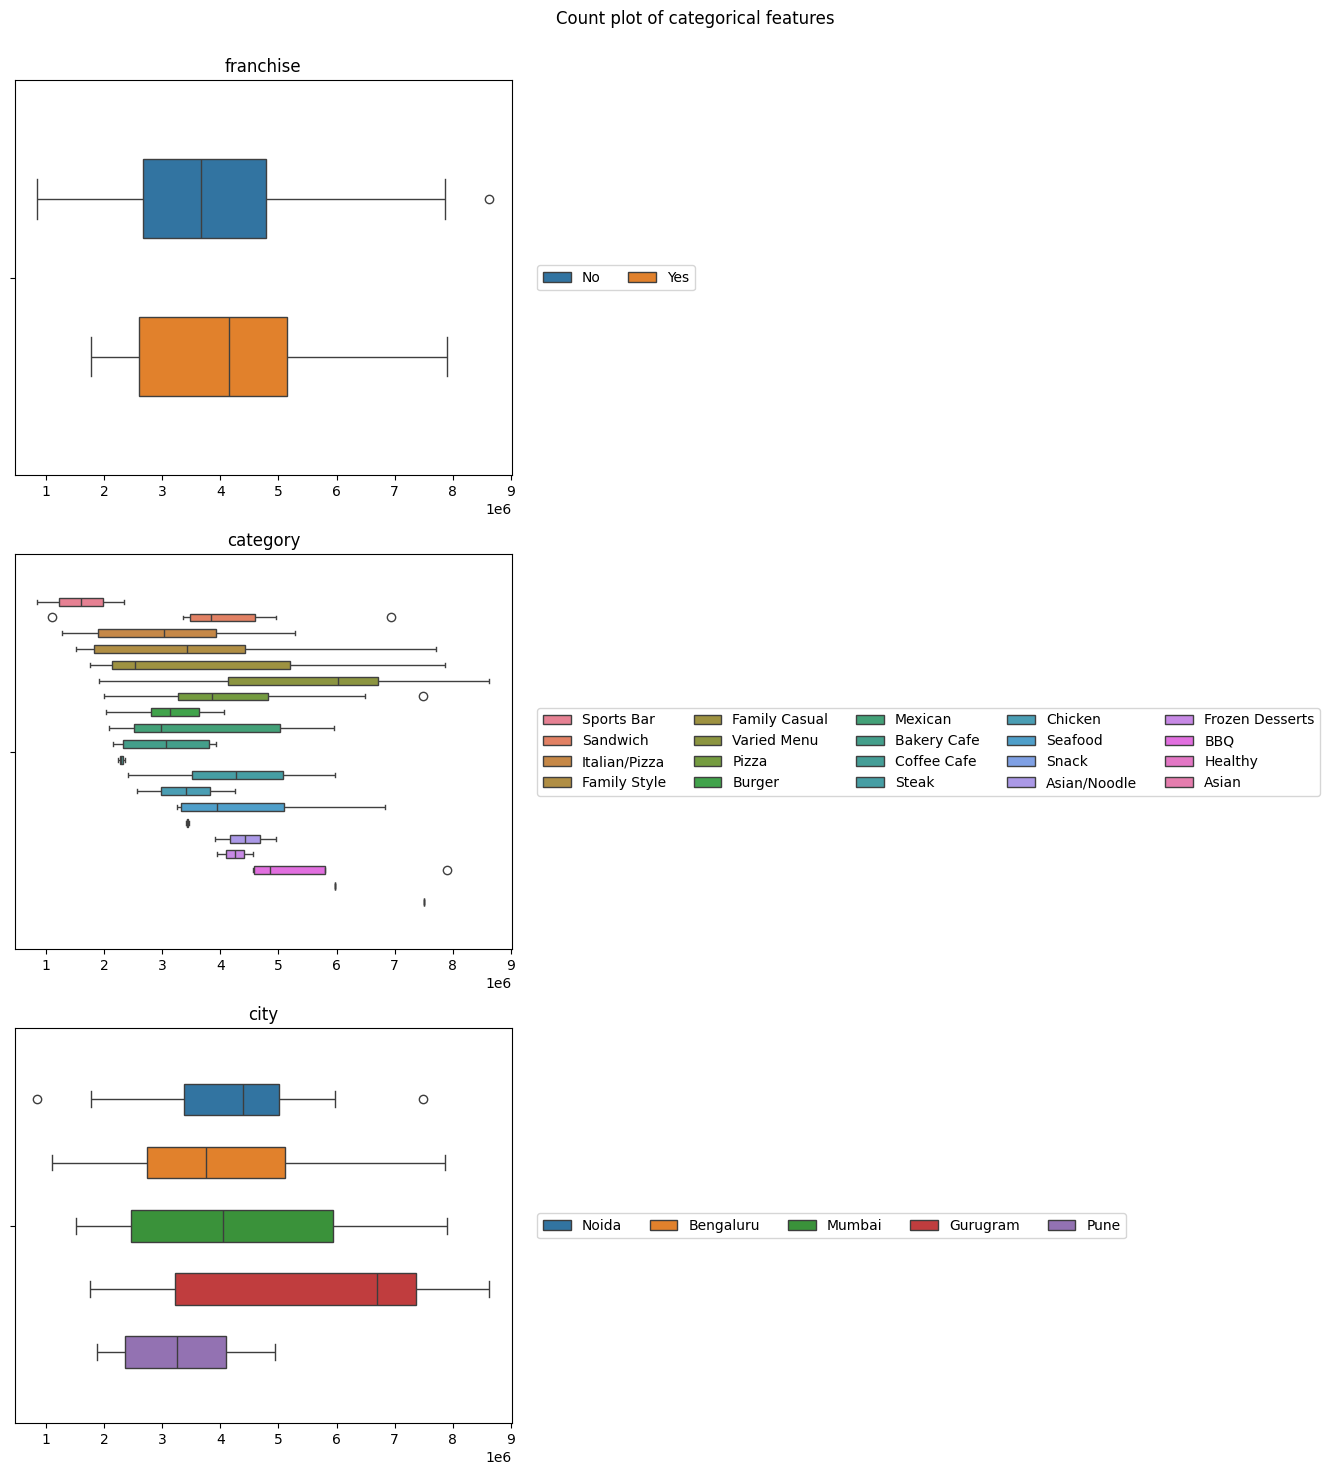

In [219]:
fig, ax = plt.subplots(nrows=len(categorical), ncols=2, figsize=(14, len(categorical)*5))

for i, col in enumerate(categorical):
    
    sns.boxplot(df, x=target, hue=col, gap=0.5, ax=ax[i, 0])
    ax[i, 0].set_title(col)
    ax[i, 0].set_xlabel('')
    handles, labels = ax[i, 0].get_legend_handles_labels()
    ax[i, 0].legend().remove()  
    ax[i, 1].legend(handles, labels, loc='center left', ncols=5)
    ax[i, 1].axis('off') 

fig.suptitle('Count plot of categorical features')
plt.tight_layout(rect=[0,0,0.96,0.98])

The above boxplot shows the distribution of revenue across various categories. The franchise/not does not have a clear seperation, indicating it as a poor predictor. Other two features has some useful patterns.

## Multivariate analysis

<Axes: >

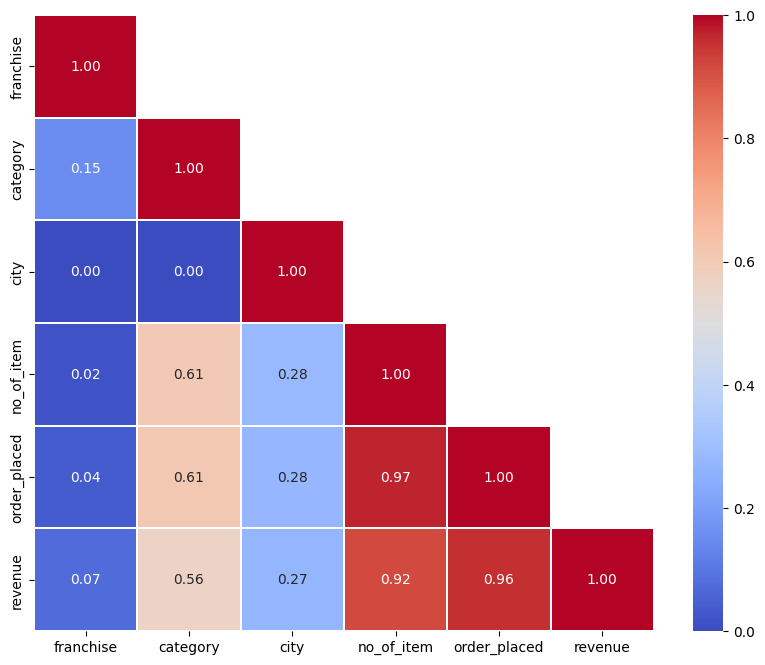

In [220]:
plt.subplots(figsize=(10,8))

corr = associations(df, compute_only=True)['corr']

sns.heatmap(corr, mask=np.triu(np.ones_like(corr), k=1), cmap='coolwarm', linewidths=0.2, annot=True, fmt='0.2f')

The correlation confirms our finding about the `franchise` column. We will drop it.

In [221]:
df.drop(columns='franchise', inplace=True)
categorical = categorical[1:]

# Model building

## Linear regression

The dataset being very simple and high correlation of variables with the target, we will use linear regression model to train the estimator.

In [222]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], random_state=42, test_size=0.2)

In [259]:
def get_transformer():
    numerical_pipe = Pipeline(
        [
            ('transformer', FunctionTransformer(func=np.log, inverse_func=np.exp)),
            ('scaler', StandardScaler())
        ]
    )

    selector = ColumnTransformer(
        [
            ('numerical', numerical_pipe, numerical),
            ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical)
        ]
    )

    model = Pipeline(
        [
            ('selector', selector)
        ]
    )
    return model

In [260]:
model = get_transformer()
model.steps.append(['predictor', LinearRegression()])

model.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('transformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['no_of_item', 'order_placed'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['category', 'city'], dtype='object'))])),
                ['predictor', LinearRegression()]])

In [261]:
model.score(X_test, y_test)

0.7970942124927431

### Statistical analysis

In [263]:
X_train_transformed = pd.DataFrame(get_transformer().fit_transform(X_train, y_train))
X_train_transformed.columns = np.concatenate([numerical, np.concatenate([y[1:] for y in df[categorical].apply(lambda x: x.unique()).values])])
X_train_transformed.index = y_train.index
lr_ols = OLS(y_train, add_constant(X_train_transformed))
model_ols = lr_ols.fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     26.23
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           2.19e-21
Time:                        16:02:20   Log-Likelihood:                -1130.8
No. Observations:                  78   AIC:                             2314.
Df Residuals:                      52   BIC:                             2375.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.871e+06   6.82e+05      5.673      0.000     2.5e+06    5.24e+06
no_of_item       7.157e+05   3.23e+05      2.218      0.031    6.82e+04    1.36e+06
order_placed     9.708e+05   3.15e+05      3.086      0.003     3.4e+05     1.6e+06
Sandwich         7.446e+04   7.99e+05      0.093      0.926   -1.53e+06    1.68e+06
Italian/Pizza    2.501e+05   7.48e+05      0.334      0.739   -1.25e+06    1.75e+06
Family Style     3.676e+05   8.06e+05      0.456      0.650   -1.25e+06    1.98e+06
Family Casual   -1.415e+05   7.37e+05     -0.192      0.848   -1.62e+06    1.34e+06
Varied Menu      6.602e+05   8.24e+05      0.802      0.426   -9.93e+05    2.31e+06
Pizza             1.09e+06   8.32e+05      1.310      0.196   -5.79e+05    2.76e+06
Burger           7.978e+05   7.54e+05      1.057      0.295   -7.16e+05    2.31e+06
Mexican          2.325e+05   7.54e+05      0.308      0.759   -1.28e+06    1.75e+06
Bakery Cafe      2.153e+05   8.02e+05      0.268      0.789   -1.39e+06    1.83e+06
Coffee Cafe      7.776e+05   9.32e+05      0.835      0.408   -1.09e+06    2.65e+06
Steak            4.165e+05   7.48e+05      0.557      0.580   -1.08e+06    1.92e+06
Chicken         -3.255e+04   7.23e+05     -0.045      0.964   -1.48e+06    1.42e+06
Seafood          3.306e+05   7.19e+05      0.459      0.648   -1.11e+06    1.77e+06
Snack            2.836e+05   7.29e+05      0.389      0.699   -1.18e+06    1.75e+06
Asian/Noodle     1.062e+05   7.51e+05      0.141      0.888    -1.4e+06    1.61e+06
Frozen Desserts -2.245e+05   8.06e+05     -0.279      0.782   -1.84e+06    1.39e+06
BBQ               8.37e+05   9.46e+05      0.885      0.380   -1.06e+06    2.74e+06
Healthy          1.936e+05   7.38e+05      0.263      0.794   -1.29e+06    1.67e+06
Asian            3.303e+05   6.61e+05      0.500      0.619   -9.96e+05    1.66e+06
Bengaluru        4.389e+05   3.18e+05      1.379      0.174      -2e+05    1.08e+06
Mumbai           6.232e+04   2.16e+05      0.289      0.774    -3.7e+05    4.95e+05
Gurugram        -8.442e+04   2.26e+05     -0.373      0.711   -5.39e+05     3.7e+05
Pune            -2.118e+05   2.47e+05     -0.857      0.395   -7.08e+05    2.84e+05
==============================================================================
Omnibus:                        5.904   Durbin-Watson:                   2.309
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                7.249
Skew:                           0.288   Prob(JB):                       0.0267
Kurtosis:                       4.378   Cond. No.                         65.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statistical analysis, we can see that all the features has high p-value, indicating high multi-collinearity. We will remove all categorical features and just use the numerical features.

## Linear regression after feature selection

In [272]:
def get_transformer_2():
    pipe = Pipeline(
        [
            ('transformer', FunctionTransformer(func=np.log, inverse_func=np.exp)),
            ('scaler', StandardScaler())
        ]
    )

    return pipe

model = get_transformer_2()
model.steps.append(['predictor', LinearRegression()])

model = pipe.fit(X_train[numerical], y_train)

In [273]:
model.score(X_test[numerical], y_test)

0.8076260284309155

### Statistical analysis

In [275]:
X_train_transformed = pd.DataFrame(get_transformer_2().fit_transform(X_train[numerical], y_train))
X_train_transformed.columns = numerical
X_train_transformed.index = y_train.index
lr_ols = OLS(y_train, add_constant(X_train_transformed))
model_ols = lr_ols.fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     335.6
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           3.83e-38
Time:                        16:11:54   Log-Likelihood:                -1143.0
No. Observations:                  78   AIC:                             2292.
Df Residuals:                      75   BIC:                             2299.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.152e+06   6.46e+04     64.287      0.000    4.02e+06    4.28e+06
no_of_item    6.551e+05   2.61e+05      2.515      0.014    1.36e+05    1.17e+06
order_placed  1.031e+06   2.61e+05      3.957      0.000    5.12e+05    1.55e+06
==============================================================================
Omnibus:                        2.774   Durbin-Watson:                   2.376
Prob(Omnibus):                  0.250   Jarque-Bera (JB):                2.167
Skew:                           0.217   Prob(JB):                        0.338
Kurtosis:                       3.692   Cond. No.                         7.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that, the p-value of no_of_item is still significant, but the adj.r-squared value has significantly increased. This shows that, with categorical features, the model tends to overfit the data. We will now use penalizing regressor (ridge) to find if the score has any improvement.

## Ridge regression

In [278]:
model_ridge = get_transformer_2()
model_ridge.steps.append(('ridge', RidgeCV()))

model_ridge.fit(X_train[numerical], y_train)

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<ufunc 'log'>,
                                     inverse_func=<ufunc 'exp'>)),
                ('scaler', StandardScaler()), ('ridge', RidgeCV())])

In [279]:
model_ridge.score(X_test[numerical], y_test)

0.8073534449059036

The ridge regressor has performed the same as linear regression.

# Discussion

The dataset being simple, we used only the linear models for the analysis as the complex models would tend to overfit the data. The model scored an r2 of 0.80, which means, the model performs better than the naive mean model by 80%.